<a href="https://colab.research.google.com/github/shreevigneshs/Shell_scripts/blob/master/1_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from typing import List
import re
import string

import torch
import torchtext
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import sklearn
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
from collections import Counter
from itertools import chain

from tqdm import tqdm

In [2]:
# df = pd.read_csv("/content/drive/MyDrive/NLP243/assignments/1/hw1_train-1.csv")
# df["split"] = "train"
# df.columns = ["id", "text", "labels", "split"]
# df.labels = df.labels.replace(np.nan, "none", regex=True)

In [3]:
# np.random.seed(20221002)
# train_proportion = 0.80
# val_proportion = 0.20

In [4]:
# item_list = list(row.to_dict() for _, row in df.iterrows())
# np.random.shuffle(item_list)

In [5]:
# # Create split data
# final_list = []

# n_total = len(item_list)
# n_train = int(train_proportion * n_total)
# n_val = int(val_proportion * n_total)

# # Give data point a split attribute
# for item in item_list[:n_train]:
#   item['split'] = 'train'
    
# for item in item_list[n_train:n_train+n_val+1]:
#   item['split'] = 'val'

# # Add to final list
# final_list.extend(item_list)

# final_df = pd.DataFrame(final_list)

In [6]:
# print(final_df)

In [30]:
def preprocess_text(text):
  text = text.lower()
  text = re.sub(r"([.,!?])", r" \1 ", text)
  text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
  return text

In [31]:
# final_df.text = final_df.text.apply(preprocess_text)

In [8]:
# print(final_df.text)

In [9]:
# final_df.to_csv("/content/drive/MyDrive/NLP243/assignments/1/clean_hw1_train-1.csv")

In [10]:
class Vocabulary(object):
    """Class to process text and extract Vocabulary for mapping"""

    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<unk>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}

        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        """ returns a dictionary that can be serialized """
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        """ instantiates the Vocabulary from a serialized dictionary """
        return cls(**contents)

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index

    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self._add_unk:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [11]:
class Vectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, text_vocab):
        """
        Args:
            review_vocab (Vocabulary): maps words to integers
            rating_vocab (Vocabulary): maps class labels to integers
        """
        self.text_vocab = text_vocab
        # self.label_vocab = label_vocab

    def vectorize(self, text):
        """Create a collapsed one-hit vector for the review
        
        Args:
            review (str): the review
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding
        """
        one_hot = np.zeros(len(self.text_vocab), dtype=np.float32)
        
        for token in text.split(" "):
            if token not in string.punctuation:
                one_hot[self.text_vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, df, cutoff=100):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            review_df (pandas.DataFrame): the review dataset
            cutoff (int): the parameter for frequency-based filtering
        Returns:
            an instance of the ReviewVectorizer
        """
        text_vocab = Vocabulary(add_unk=True)
        
        # label_vocab = Vocabulary(add_unk=False)
        
        # # Add ratings
        # for rating in sorted(set(df.labels)):
        #     rating_vocab.add_token(rating)

        # Add top words if count > provided count
        word_counts = Counter()
        for text in df.text:
            for word in text.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
        
        # print(word_counts.most_common(100))

        for word, count in dict(word_counts.most_common(cutoff)).items():
            text_vocab.add_token(word)
        
        # for word, count in word_counts.items():
        #     if count > cutoff:
        #         text_vocab.add_token(word)

        # return cls(review_vocab, rating_vocab)
        
        return cls(text_vocab)

    @classmethod
    def from_serializable(cls, contents):
        """Intantiate a ReviewVectorizer from a serializable dictionary
        
        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the ReviewVectorizer class
        """
        text_vocab = Vocabulary.from_serializable(contents['text_vocab'])
        
        # rating_vocab =  Vocabulary.from_serializable(contents['rating_vocab'])

        # return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)

        return cls(text_vocab=text_vocab)

    def to_serializable(self):
        """Create the serializable dictionary for caching
        
        Returns:
            contents (dict): the serializable dictionary
        """
        # return {'review_vocab': self.review_vocab.to_serializable(),
        #         'rating_vocab': self.rating_vocab.to_serializable()}

        return {'text_vocab': self.text_vocab.to_serializable()}

In [12]:
# Label Indexer
# For converting labels into indices 0 - L1, 1 - L2

class LabelIndexer(object):
    def __init__(self, labels):

        # self.labels = list(set([_split_label for label in movie_df.labels.unique().flatten() for _split_label in label.split()]))
        
        self.labels = labels
        self.n_labels = len(self.labels)
        self.label2idx = {label: i for i, label in enumerate(self.labels)}
        self.idx2label = {i:label for label, i in self.label2idx.items()}

    def encode(self, y):
        one_hot_encoded = np.zeros(self.n_labels, dtype=int)
        normalized_label = list(set([_split_label for _split_label in y.split()]))
        for _label in normalized_label:
          one_hot_encoded[self.label2idx[_label]] = 1.
        return one_hot_encoded

    def encode_batch(self, ys):
        return torch.LongTensor([self.encode(y) for y in ys])
    
    @classmethod
    def from_dataframe(cls, df):
        labels = list(set([_split_label for label in df.labels.unique().flatten() for _split_label in label.split()]))
        return cls(labels)
    
    @classmethod
    def from_serializable(cls, contents):
        """Intantiate a ReviewVectorizer from a serializable dictionary
        
        Args:
            contents (dict): the serializable dictionary
        Returns:
            an instance of the ReviewVectorizer class
        """
        labels = LabelIndexer.from_serializable(contents['labels'])
        
        # rating_vocab =  Vocabulary.from_serializable(contents['rating_vocab'])

        # return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)

        return cls(labels=labels)

    def to_serializable(self):
        """Create the serializable dictionary for caching
        
        Returns:
            contents (dict): the serializable dictionary
        """
        # return {'review_vocab': self.review_vocab.to_serializable(),
        #         'rating_vocab': self.rating_vocab.to_serializable()}

        return {'labels': self.labels.to_serializable()}
    
    def __str__(self):
        return "<LabelIndexer(size=%d)>" % len(self)

    def __len__(self):
        return self.n_labels


In [13]:
class MovieDataset(Dataset):
    def __init__(self, movie_df, vectorizer, label_indexer):
        """
        Args:
            movie_df (pandas.DataFrame): the dataset
            vectorizer (ReviewVectorizer): vectorizer instantiated from dataset
        """
        self.movie_df = movie_df
        self._vectorizer = vectorizer
        self._label_indexer = label_indexer

        self.train_df = self.movie_df[self.movie_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.movie_df[self.movie_df.split=='val']
        self.validation_size = len(self.val_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer_and_label_indexer(cls, movie_csv):
        """Load dataset and make a new vectorizer from scratch
        
        Args:
            review_csv (str): location of the dataset
        Returns:
            an instance of ReviewDataset
        """
        movie_df = pd.read_csv(movie_csv)

        return cls(movie_df, Vectorizer.from_dataframe(movie_df), LabelIndexer.from_dataframe(movie_df))

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer
    
    def get_label_indexer(self):
        """ returns label indexer """
        return self._label_indexer

    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        
        Args:
            split (str): one of "train" or "val"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dict of the data point's features (x_data) and label (y_target)
        """
        row = self._target_df.iloc[index]

        text_vector = \
            self._vectorizer.vectorize(row.text)

        label_index = \
            self._label_indexer.encode(row.labels)

        return {'x_data': text_vector,
                'y_target': label_index}

    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size

In [14]:
dataset = MovieDataset.load_dataset_and_make_vectorizer_and_label_indexer(movie_csv="/content/drive/MyDrive/NLP243/assignments/1/clean_hw1_train-1.csv")
vectorizer = dataset.get_vectorizer()

In [15]:
# data loader

def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [16]:
batched_data = generate_batches(dataset=dataset, batch_size=2)

In [17]:
# Zipping the dataloader with range(N) lets us only print the first N batches
for _, batch in zip(range(5), batched_data):
    print(batch["x_data"].shape, batch["y_target"].shape)
    # Do something here; maybe print the batch to see if it looks right to you?
    # print(batch.shape)

torch.Size([2, 101]) torch.Size([2, 19])
torch.Size([2, 101]) torch.Size([2, 19])
torch.Size([2, 101]) torch.Size([2, 19])
torch.Size([2, 101]) torch.Size([2, 19])
torch.Size([2, 101]) torch.Size([2, 19])


In [18]:
import torch.nn as nn
import torch.nn.functional as F

class MLPMultiLabelClassifier(nn.Module):
    """ a simple perceptron-based classifier """
    def __init__(self, input_size, hidden_size, output_size, dropout_p=0.1):
        super(MLPMultiLabelClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=input_size, 
                             out_features=hidden_size, bias=True)
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=output_size, bias=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, x_in):
        y1_out = F.relu(self.fc1(x_in).squeeze())
        y2_out = self.fc2(self.dropout(y1_out)).squeeze()
        y_out = y2_out
        return y_out

In [19]:
from argparse import Namespace

args = Namespace(
    # Data and path information
    frequency_cutoff=25,
    model_state_file='/content/drive/MyDrive/NLP243/assignments/1/model/20221002/model_1.pth',
    movie_csv='/content/drive/MyDrive/NLP243/assignments/1/clean_hw1_train-1.csv',
    save_dir='/content/drive/MyDrive/NLP243/assignments/1/model/20221002/',
    # vectorizer_file='vectorizer.json',
    # No model hyperparameters
    # Training hyperparameters
    batch_size=64,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=100,
    seed=20220310,
    # Runtime options omitted for space
)

if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")

In [20]:
# training state
def make_train_state(args):
    return {'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'train_p': [],
            'train_r': [],
            'train_f1': [],
            'train_classification_report': [],
            'val_loss': [],
            'val_acc': [],
            'val_p': [],
            'val_r': [],
            'val_f1': [],
            'val_classification_report': [],
            'test_loss': -1,
            'test_acc': -1}
train_state = make_train_state(args)

# instantiate dataset

# dataset and vectorizer
dataset = MovieDataset.load_dataset_and_make_vectorizer_and_label_indexer(args.movie_csv)
vectorizer = dataset.get_vectorizer()
label_indexer = dataset.get_label_indexer()
labels = [label_indexer.idx2label[_idx] for _idx in range(len(label_indexer))]

# model
classifier = MLPMultiLabelClassifier(input_size=len(vectorizer.text_vocab), hidden_size=100, output_size=len(label_indexer))
classifier = classifier.to(args.device)

# loss and optimizer
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate, weight_decay=1e-4)

for epoch_index in range(args.num_epochs):
    train_state['epoch_index'] = epoch_index

    # Iterate over training dataset

    # setup: batch generator, set loss and acc to 0, set train mode on
    dataset.set_split('train')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.0
    running_acc = 0.0
    running_p = 0.0
    running_r = 0.0
    running_f1 = 0.0

    batch_wise_true_labels = []
    batch_wise_predictions = []

    classifier.train()

    for batch_index, batch_dict in enumerate(batch_generator):
        # the training routine is 5 steps:

        # step 1. zero the gradients
        optimizer.zero_grad()

        # step 2. compute the output
        y_pred = classifier(x_in=batch_dict['x_data'].float())
        
        # print("y_pred: {}".format(y_pred))

        # step 3. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].squeeze().float())
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)

        # step 4. use loss to produce gradients
        loss.backward()

        # clip the grad norm
        nn.utils.clip_grad_norm_(classifier.parameters(), 3.0)

        # step 5. use optimizer to take gradient step
        optimizer.step()

        # -----------------------------------------
        # compute the metrics

        y_pred_normalized = F.sigmoid(y_pred)
        y_pred_labels = y_pred_normalized >= 0.5
        
        batch_wise_true_labels.append(batch_dict['y_target'].tolist())
        batch_wise_predictions.append(y_pred_labels.tolist())

        # p_batch, r_batch, f1_batch = compute_metrics(F.sigmoid(y_pred), batch_dict['y_target'].squeeze())
        # running_p += (p_batch - running_p) / (batch_index + 1)
        # running_r += (r_batch - running_r) / (batch_index + 1)
        # running_f1 += (f1_batch - running_f1) / (batch_index + 1)

    all_true_labels = list(chain.from_iterable(batch_wise_true_labels))
    all_predictions = list(chain.from_iterable(batch_wise_predictions))

    # Now we can generate a classification report
    print("Train classification report after epoch:")
    train_state['train_classification_report'] = classification_report(all_true_labels, all_predictions, target_names=labels)
    print(train_state['train_classification_report'])


    train_state['train_loss'].append(running_loss)
    train_state['train_acc'].append(running_acc)
    train_state['train_p'].append(running_p)
    train_state['train_r'].append(running_r)
    train_state['train_f1'].append(running_f1)

    # Iterate over val dataset

    # setup: batch generator, set loss and acc to 0, set eval mode on
    dataset.set_split('val')
    batch_generator = generate_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
    running_loss = 0.
    running_acc = 0.
    running_p = 0.0
    running_r = 0.0
    running_f1 = 0.0
    classifier.eval()

    batch_wise_true_labels = []
    batch_wise_predictions = []

    for batch_index, batch_dict in enumerate(batch_generator):

        # step 1. compute the output
        y_pred = classifier(x_in=batch_dict['x_data'].float())

        # step 2. compute the loss
        loss = loss_func(y_pred, batch_dict['y_target'].squeeze().float())
        loss_batch = loss.item()
        running_loss += (loss_batch - running_loss) / (batch_index + 1)

        # step 3. compute the metrics

        y_pred_normalized = F.sigmoid(y_pred)
        y_pred_labels = y_pred_normalized >= 0.5
        
        batch_wise_true_labels.append(batch_dict['y_target'].tolist())
        batch_wise_predictions.append(y_pred_labels.tolist())
        
        # p_batch, r_batch, f1_batch = compute_metrics(F.sigmoid(y_pred), batch_dict['y_target'].squeeze())
        # running_p += (p_batch - running_p) / (batch_index + 1)
        # running_r += (r_batch - running_r) / (batch_index + 1)
        # running_f1 += (f1_batch - running_f1) / (batch_index + 1)

        # acc_batch = compute_accuracy(y_pred, batch_dict['y_target'])
        # running_acc += (acc_batch - running_acc) / (batch_index + 1)


    all_true_labels = list(chain.from_iterable(batch_wise_true_labels))
    all_predictions = list(chain.from_iterable(batch_wise_predictions))

    # Now we can generate a classification report
    print("Val classification report after epoch:")
    train_state['val_classification_report'] = classification_report(all_true_labels, all_predictions, target_names=labels)
    print(train_state['val_classification_report'])

    train_state['val_loss'].append(running_loss)
    train_state['val_acc'].append(running_acc)
    train_state['val_p'].append(running_p)
    train_state['val_r'].append(running_r)
    train_state['val_f1'].append(running_f1)

# Training done, let's look at the loss curves
all_train_running_losses = list(chain.from_iterable(train_state['train_loss']))
all_valid_running_losses = list(chain.from_iterable(train_state['val_loss']))

train_epoch_idx = range(len(train_state['train_loss']))
valid_epoch_idx = range(len(train_state['val_loss']))
# sns.lineplot(epoch_idx, all_losses)
sns.lineplot(train_epoch_idx, all_train_running_losses)
sns.lineplot(valid_epoch_idx, all_valid_running_losses)
plt.show()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.09      0.01      0.01       267
              movie.rating       0.08      0.41      0.14       165
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.50      0.00         2
      person.date_of_birth       0.01      0.20      0.02         5
movie.initial_release_date       0.07      0.07      0.07       143
            movie.language       0.11      0.16      0.13       173
         movie.produced_by       0.23      0.04      0.06       142
         movie.directed_by       0.38      0.01      0.02       260
       movie.gross_revenue       0.03      0.08      0.04        24
           movie.locations       0.00      0.33      0.00         3
             movie.country       0.08      0.26      0.12       170
    movie.estimated_budget       0.06      0.03      0.04        60
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.00      0.00      0.00       265
              movie.rating       0.00      0.00      0.00       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         2
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.00      0.00      0.00       141
            movie.language       0.00      0.00      0.00       177
         movie.produced_by       0.00      0.00      0.00       140
         movie.directed_by       0.00      0.00      0.00       263
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.00      0.00      0.00       172
    movie.estimated_budget       0.00      0.00      0.00        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWar

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.00      0.00      0.00       270
              movie.rating       0.00      0.00      0.00       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.00      0.00      0.00       140
            movie.language       0.00      0.00      0.00       174
         movie.produced_by       0.00      0.00      0.00       141
         movie.directed_by       0.00      0.00      0.00       261
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.00      0.00      0.00       172
    movie.estimated_budget       0.00      0.00      0.00        60
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWar

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.00      0.00      0.00       261
              movie.rating       0.00      0.00      0.00       166
              actor.gender       0.00      0.00      0.00         4
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.00      0.00      0.00       140
            movie.language       0.00      0.00      0.00       175
         movie.produced_by       0.00      0.00      0.00       143
         movie.directed_by       0.00      0.00      0.00       256
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.00      0.00      0.00       173
    movie.estimated_budget       0.00      0.00      0.00        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWar

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.00      0.00      0.00       270
              movie.rating       0.00      0.00      0.00       163
              actor.gender       0.00      0.00      0.00         4
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.00      0.00      0.00       140
            movie.language       0.00      0.00      0.00       179
         movie.produced_by       0.00      0.00      0.00       142
         movie.directed_by       0.00      0.00      0.00       257
       movie.gross_revenue       0.00      0.00      0.00        25
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.00      0.00      0.00       171
    movie.estimated_budget       0.00      0.00      0.00        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWar

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.00      0.00      0.00       269
              movie.rating       0.00      0.00      0.00       162
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.00      0.00      0.00       141
            movie.language       0.00      0.00      0.00       175
         movie.produced_by       0.00      0.00      0.00       140
         movie.directed_by       0.00      0.00      0.00       258
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.00      0.00      0.00       171
    movie.estimated_budget       0.00      0.00      0.00        60
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWar

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.00      0.01       264
              movie.rating       0.00      0.00      0.00       163
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.00      0.00      0.00       139
            movie.language       0.00      0.00      0.00       179
         movie.produced_by       0.00      0.00      0.00       142
         movie.directed_by       0.00      0.00      0.00       258
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.00      0.00      0.00       174
    movie.estimated_budget       0.00      0.00      0.00        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.02      0.04       267
              movie.rating       0.00      0.00      0.00       167
              actor.gender       0.00      0.00      0.00         3
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         4
movie.initial_release_date       0.00      0.00      0.00       143
            movie.language       0.00      0.00      0.00       178
         movie.produced_by       0.00      0.00      0.00       141
         movie.directed_by       1.00      0.05      0.09       263
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.00      0.00      0.00       168
    movie.estimated_budget       0.00      0.00      0.00        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.06      0.11       265
              movie.rating       1.00      0.05      0.09       167
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       1.00      0.01      0.01       140
            movie.language       0.00      0.00      0.00       177
         movie.produced_by       0.00      0.00      0.00       141
         movie.directed_by       0.98      0.21      0.34       256
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.00      0.00      0.00       174
    movie.estimated_budget       0.00      0.00      0.00        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       1.00      0.15      0.26       270
              movie.rating       1.00      0.24      0.38       161
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       1.00      0.24      0.39       141
            movie.language       1.00      0.03      0.05       177
         movie.produced_by       1.00      0.01      0.01       142
         movie.directed_by       0.98      0.33      0.49       260
       movie.gross_revenue       0.00      0.00      0.00        25
           movie.locations       0.00      0.00      0.00         3
             movie.country       1.00      0.01      0.01       172
    movie.estimated_budget       0.00      0.00      0.00        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.98      0.22      0.35       265
              movie.rating       1.00      0.40      0.57       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       1.00      0.38      0.55       142
            movie.language       1.00      0.10      0.18       177
         movie.produced_by       1.00      0.04      0.07       142
         movie.directed_by       0.96      0.47      0.63       262
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       1.00      0.03      0.06       175
    movie.estimated_budget       0.00      0.00      0.00        60
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.99      0.27      0.43       266
              movie.rating       1.00      0.51      0.68       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.99      0.50      0.66       139
            movie.language       1.00      0.15      0.26       174
         movie.produced_by       0.72      0.13      0.22       141
         movie.directed_by       0.96      0.51      0.67       263
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       1.00      0.05      0.10       173
    movie.estimated_budget       0.00      0.00      0.00        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.95      0.31      0.46       270
              movie.rating       1.00      0.62      0.77       166
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       1.00      0.58      0.74       142
            movie.language       0.96      0.27      0.42       175
         movie.produced_by       0.84      0.34      0.49       143
         movie.directed_by       0.94      0.56      0.70       256
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.90      0.11      0.19       174
    movie.estimated_budget       1.00      0.07      0.12        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.95      0.37      0.53       270
              movie.rating       1.00      0.71      0.83       164
              actor.gender       0.00      0.00      0.00         4
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.99      0.60      0.75       142
            movie.language       0.99      0.37      0.54       178
         movie.produced_by       0.81      0.55      0.66       142
         movie.directed_by       0.96      0.58      0.72       259
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.86      0.14      0.24       176
    movie.estimated_budget       1.00      0.14      0.25        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.42      0.58       270
              movie.rating       1.00      0.74      0.85       163
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.99      0.63      0.77       143
            movie.language       0.96      0.40      0.56       172
         movie.produced_by       0.82      0.65      0.72       141
         movie.directed_by       0.95      0.63      0.76       258
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.87      0.25      0.38       166
    movie.estimated_budget       1.00      0.31      0.47        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.93      0.47      0.62       269
              movie.rating       1.00      0.79      0.88       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.99      0.64      0.78       144
            movie.language       0.99      0.47      0.64       177
         movie.produced_by       0.84      0.65      0.73       143
         movie.directed_by       0.93      0.64      0.76       255
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.83      0.23      0.35       173
    movie.estimated_budget       0.96      0.44      0.60        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.93      0.50      0.65       269
              movie.rating       1.00      0.80      0.89       161
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.99      0.64      0.77       140
            movie.language       0.96      0.45      0.62       176
         movie.produced_by       0.83      0.79      0.81       142
         movie.directed_by       0.94      0.67      0.78       260
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.88      0.34      0.49       175
    movie.estimated_budget       0.94      0.54      0.69        59
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.93      0.51      0.66       266
              movie.rating       1.00      0.82      0.90       168
              actor.gender       0.00      0.00      0.00         4
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.99      0.69      0.82       140
            movie.language       0.98      0.52      0.68       178
         movie.produced_by       0.82      0.77      0.79       143
         movie.directed_by       0.92      0.67      0.78       255
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.88      0.30      0.45       174
    movie.estimated_budget       0.93      0.63      0.75        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.54      0.68       268
              movie.rating       1.00      0.83      0.91       163
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.99      0.67      0.80       142
            movie.language       0.98      0.54      0.69       177
         movie.produced_by       0.83      0.84      0.83       143
         movie.directed_by       0.94      0.68      0.79       256
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.91      0.41      0.57       169
    movie.estimated_budget       0.96      0.70      0.81        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.56      0.70       267
              movie.rating       1.00      0.82      0.90       166
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         2
      person.date_of_birth       0.00      0.00      0.00         4
movie.initial_release_date       0.99      0.66      0.79       140
            movie.language       0.98      0.53      0.69       176
         movie.produced_by       0.82      0.83      0.83       143
         movie.directed_by       0.93      0.69      0.79       258
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.88      0.41      0.56       174
    movie.estimated_budget       0.94      0.79      0.86        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.88      0.59      0.70       263
              movie.rating       1.00      0.82      0.90       165
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         4
movie.initial_release_date       0.98      0.67      0.80       141
            movie.language       0.99      0.56      0.71       178
         movie.produced_by       0.83      0.83      0.83       145
         movie.directed_by       0.92      0.71      0.80       256
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.95      0.42      0.58       175
    movie.estimated_budget       0.96      0.73      0.83        60
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.59      0.71       268
              movie.rating       1.00      0.84      0.91       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.99      0.69      0.81       142
            movie.language       0.97      0.60      0.74       176
         movie.produced_by       0.83      0.83      0.83       143
         movie.directed_by       0.94      0.71      0.81       256
       movie.gross_revenue       0.00      0.00      0.00        24
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.90      0.44      0.59       172
    movie.estimated_budget       0.96      0.84      0.90        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.63      0.75       268
              movie.rating       1.00      0.84      0.92       161
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.98      0.69      0.81       144
            movie.language       0.97      0.60      0.74       175
         movie.produced_by       0.84      0.86      0.85       142
         movie.directed_by       0.93      0.73      0.81       255
       movie.gross_revenue       0.00      0.00      0.00        25
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.91      0.46      0.61       171
    movie.estimated_budget       0.92      0.77      0.84        60
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.62      0.74       270
              movie.rating       1.00      0.85      0.92       163
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         2
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.68      0.80       134
            movie.language       0.97      0.62      0.76       178
         movie.produced_by       0.85      0.86      0.85       142
         movie.directed_by       0.93      0.71      0.81       256
       movie.gross_revenue       0.00      0.00      0.00        25
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.92      0.45      0.61       176
    movie.estimated_budget       0.94      0.82      0.88        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.89      0.61      0.72       267
              movie.rating       1.00      0.84      0.91       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         2
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.98      0.71      0.83       140
            movie.language       0.98      0.59      0.74       177
         movie.produced_by       0.84      0.83      0.84       142
         movie.directed_by       0.91      0.75      0.82       256
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.94      0.51      0.66       175
    movie.estimated_budget       0.93      0.85      0.88        59
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.66      0.76       266
              movie.rating       1.00      0.84      0.91       165
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         4
movie.initial_release_date       0.99      0.68      0.81       142
            movie.language       0.97      0.63      0.76       174
         movie.produced_by       0.83      0.89      0.86       144
         movie.directed_by       0.93      0.72      0.81       254
       movie.gross_revenue       0.00      0.00      0.00        25
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.93      0.52      0.66       172
    movie.estimated_budget       0.93      0.86      0.89        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.64      0.75       269
              movie.rating       1.00      0.85      0.92       159
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.71      0.82       143
            movie.language       0.97      0.62      0.76       179
         movie.produced_by       0.82      0.87      0.84       141
         movie.directed_by       0.93      0.74      0.82       260
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.91      0.49      0.64       169
    movie.estimated_budget       0.93      0.84      0.88        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.66      0.76       265
              movie.rating       1.00      0.85      0.92       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.98      0.70      0.81       142
            movie.language       0.95      0.68      0.79       173
         movie.produced_by       0.85      0.86      0.86       140
         movie.directed_by       0.93      0.77      0.84       260
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         2
             movie.country       0.89      0.54      0.67       171
    movie.estimated_budget       0.95      0.84      0.89        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.63      0.75       268
              movie.rating       1.00      0.86      0.92       168
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         2
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.98      0.72      0.83       138
            movie.language       0.98      0.64      0.77       176
         movie.produced_by       0.84      0.87      0.86       144
         movie.directed_by       0.91      0.77      0.83       254
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.94      0.53      0.68       169
    movie.estimated_budget       0.93      0.84      0.88        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.65      0.76       265
              movie.rating       1.00      0.85      0.92       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.98      0.70      0.82       142
            movie.language       0.95      0.68      0.79       179
         movie.produced_by       0.83      0.87      0.85       140
         movie.directed_by       0.91      0.75      0.82       259
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.91      0.50      0.64       176
    movie.estimated_budget       0.93      0.85      0.89        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.64      0.75       263
              movie.rating       1.00      0.86      0.92       163
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.98      0.71      0.82       144
            movie.language       0.97      0.67      0.79       178
         movie.produced_by       0.84      0.87      0.86       143
         movie.directed_by       0.92      0.76      0.83       258
       movie.gross_revenue       0.00      0.00      0.00        24
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.89      0.57      0.69       175
    movie.estimated_budget       0.93      0.89      0.91        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.87      0.67      0.76       266
              movie.rating       1.00      0.88      0.94       167
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.71      0.82       142
            movie.language       0.96      0.64      0.77       177
         movie.produced_by       0.85      0.85      0.85       138
         movie.directed_by       0.91      0.75      0.82       255
       movie.gross_revenue       0.00      0.00      0.00        25
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.93      0.53      0.67       175
    movie.estimated_budget       0.95      0.86      0.90        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.65      0.76       266
              movie.rating       1.00      0.89      0.94       166
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.99      0.72      0.84       141
            movie.language       0.97      0.67      0.79       174
         movie.produced_by       0.85      0.87      0.86       141
         movie.directed_by       0.91      0.77      0.83       255
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.93      0.54      0.68       171
    movie.estimated_budget       0.93      0.87      0.90        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.67      0.77       266
              movie.rating       1.00      0.88      0.93       161
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.72      0.83       142
            movie.language       0.92      0.68      0.78       177
         movie.produced_by       0.86      0.85      0.85       141
         movie.directed_by       0.92      0.77      0.84       261
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.91      0.56      0.69       176
    movie.estimated_budget       0.94      0.86      0.90        59
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.88      0.67      0.76       269
              movie.rating       1.00      0.86      0.92       163
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.98      0.72      0.83       138
            movie.language       0.94      0.68      0.79       177
         movie.produced_by       0.83      0.83      0.83       143
         movie.directed_by       0.92      0.77      0.84       258
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.91      0.55      0.68       170
    movie.estimated_budget       0.93      0.85      0.89        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.67      0.77       270
              movie.rating       1.00      0.88      0.94       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.99      0.73      0.84       142
            movie.language       0.95      0.70      0.81       181
         movie.produced_by       0.86      0.87      0.86       143
         movie.directed_by       0.92      0.79      0.85       254
       movie.gross_revenue       0.00      0.00      0.00        25
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.93      0.58      0.71       175
    movie.estimated_budget       0.95      0.89      0.92        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.89      0.67      0.77       264
              movie.rating       1.00      0.87      0.93       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         2
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.98      0.73      0.84       142
            movie.language       0.95      0.68      0.79       172
         movie.produced_by       0.88      0.88      0.88       145
         movie.directed_by       0.92      0.78      0.85       260
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.90      0.53      0.67       172
    movie.estimated_budget       0.93      0.85      0.89        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.66      0.76       267
              movie.rating       1.00      0.87      0.93       165
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.73      0.83       141
            movie.language       0.94      0.70      0.80       177
         movie.produced_by       0.82      0.86      0.84       138
         movie.directed_by       0.92      0.77      0.84       260
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.89      0.57      0.70       174
    movie.estimated_budget       0.95      0.86      0.90        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.87      0.67      0.76       268
              movie.rating       1.00      0.87      0.93       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         4
movie.initial_release_date       0.98      0.72      0.83       141
            movie.language       0.97      0.70      0.81       180
         movie.produced_by       0.88      0.87      0.87       142
         movie.directed_by       0.92      0.79      0.85       256
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.95      0.54      0.69       176
    movie.estimated_budget       0.95      0.89      0.92        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.88      0.68      0.77       270
              movie.rating       1.00      0.88      0.94       162
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.98      0.75      0.85       142
            movie.language       0.95      0.71      0.81       179
         movie.produced_by       0.85      0.87      0.86       140
         movie.directed_by       0.93      0.78      0.85       260
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.91      0.57      0.70       174
    movie.estimated_budget       0.93      0.89      0.91        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.68      0.78       270
              movie.rating       1.00      0.90      0.95       165
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.71      0.82       141
            movie.language       0.93      0.72      0.81       175
         movie.produced_by       0.88      0.87      0.87       141
         movie.directed_by       0.91      0.78      0.84       258
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.91      0.56      0.69       173
    movie.estimated_budget       0.95      0.84      0.89        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.88      0.69      0.78       267
              movie.rating       1.00      0.88      0.94       165
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.76      0.85       141
            movie.language       0.95      0.70      0.81       178
         movie.produced_by       0.88      0.87      0.87       143
         movie.directed_by       0.93      0.76      0.84       254
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.91      0.54      0.68       173
    movie.estimated_budget       0.95      0.87      0.91        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.67      0.77       262
              movie.rating       1.00      0.88      0.94       165
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         4
movie.initial_release_date       0.97      0.70      0.81       140
            movie.language       0.96      0.71      0.82       177
         movie.produced_by       0.87      0.87      0.87       143
         movie.directed_by       0.92      0.77      0.84       263
       movie.gross_revenue       0.00      0.00      0.00        25
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.95      0.62      0.75       169
    movie.estimated_budget       0.94      0.85      0.89        59
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.68      0.78       272
              movie.rating       1.00      0.87      0.93       161
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.73      0.84       142
            movie.language       0.92      0.72      0.81       170
         movie.produced_by       0.87      0.85      0.86       141
         movie.directed_by       0.92      0.81      0.86       256
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.90      0.60      0.72       172
    movie.estimated_budget       0.95      0.86      0.90        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.87      0.68      0.76       268
              movie.rating       1.00      0.89      0.94       162
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.73      0.83       137
            movie.language       0.97      0.70      0.82       179
         movie.produced_by       0.86      0.87      0.87       141
         movie.directed_by       0.93      0.78      0.84       255
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.95      0.61      0.75       173
    movie.estimated_budget       0.93      0.89      0.91        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.70      0.79       266
              movie.rating       1.00      0.89      0.94       167
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.76      0.85       143
            movie.language       0.95      0.72      0.82       172
         movie.produced_by       0.86      0.86      0.86       140
         movie.directed_by       0.90      0.79      0.84       261
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.92      0.63      0.75       169
    movie.estimated_budget       0.94      0.86      0.90        58
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.89      0.67      0.77       266
              movie.rating       1.00      0.87      0.93       163
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.73      0.83       141
            movie.language       0.95      0.71      0.81       178
         movie.produced_by       0.87      0.87      0.87       140
         movie.directed_by       0.92      0.80      0.85       256
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.92      0.54      0.68       174
    movie.estimated_budget       0.96      0.84      0.89        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.89      0.67      0.76       269
              movie.rating       1.00      0.90      0.95       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.73      0.84       143
            movie.language       0.91      0.71      0.80       177
         movie.produced_by       0.87      0.87      0.87       141
         movie.directed_by       0.90      0.78      0.84       254
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.88      0.58      0.70       173
    movie.estimated_budget       0.93      0.86      0.89        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.71      0.80       273
              movie.rating       1.00      0.87      0.93       163
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         2
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.74      0.84       144
            movie.language       0.96      0.72      0.82       177
         movie.produced_by       0.88      0.87      0.87       140
         movie.directed_by       0.92      0.79      0.85       257
       movie.gross_revenue       0.00      0.00      0.00        25
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.92      0.59      0.72       175
    movie.estimated_budget       0.95      0.87      0.90        60
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.68      0.78       264
              movie.rating       1.00      0.88      0.94       163
              actor.gender       0.00      0.00      0.00         4
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.76      0.85       139
            movie.language       0.96      0.74      0.84       178
         movie.produced_by       0.87      0.88      0.87       142
         movie.directed_by       0.93      0.77      0.84       258
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.94      0.59      0.72       175
    movie.estimated_budget       0.94      0.86      0.90        59
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.69      0.78       266
              movie.rating       1.00      0.92      0.96       165
              actor.gender       0.00      0.00      0.00         4
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.74      0.84       140
            movie.language       0.98      0.72      0.83       180
         movie.produced_by       0.87      0.87      0.87       141
         movie.directed_by       0.93      0.78      0.85       255
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.92      0.58      0.71       175
    movie.estimated_budget       0.98      0.85      0.91        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.70      0.78       270
              movie.rating       0.99      0.90      0.94       162
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.76      0.85       140
            movie.language       0.96      0.75      0.84       178
         movie.produced_by       0.86      0.86      0.86       139
         movie.directed_by       0.93      0.80      0.86       257
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.90      0.61      0.72       173
    movie.estimated_budget       0.96      0.87      0.92        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.70      0.79       269
              movie.rating       1.00      0.89      0.94       166
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.76      0.85       142
            movie.language       0.94      0.74      0.83       176
         movie.produced_by       0.91      0.86      0.88       146
         movie.directed_by       0.93      0.80      0.86       257
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.91      0.58      0.71       173
    movie.estimated_budget       0.93      0.87      0.90        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.70      0.79       268
              movie.rating       1.00      0.88      0.94       162
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.98      0.75      0.85       136
            movie.language       0.96      0.72      0.83       181
         movie.produced_by       0.85      0.86      0.86       140
         movie.directed_by       0.93      0.81      0.87       257
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.92      0.56      0.70       174
    movie.estimated_budget       0.95      0.89      0.92        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.89      0.69      0.78       265
              movie.rating       1.00      0.89      0.94       163
              actor.gender       0.00      0.00      0.00         4
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         4
movie.initial_release_date       0.98      0.73      0.84       142
            movie.language       0.94      0.75      0.84       178
         movie.produced_by       0.86      0.88      0.87       143
         movie.directed_by       0.92      0.80      0.86       259
       movie.gross_revenue       0.00      0.00      0.00        25
           movie.locations       0.00      0.00      0.00         2
             movie.country       0.92      0.61      0.73       172
    movie.estimated_budget       0.93      0.84      0.88        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.69      0.78       266
              movie.rating       1.00      0.89      0.94       157
              actor.gender       0.00      0.00      0.00         4
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.74      0.84       140
            movie.language       0.95      0.72      0.82       180
         movie.produced_by       0.88      0.86      0.87       143
         movie.directed_by       0.94      0.80      0.86       259
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.95      0.59      0.72       177
    movie.estimated_budget       0.95      0.87      0.91        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.87      0.71      0.78       269
              movie.rating       1.00      0.88      0.94       164
              actor.gender       0.00      0.00      0.00         4
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.75      0.84       142
            movie.language       0.97      0.71      0.82       175
         movie.produced_by       0.89      0.88      0.88       144
         movie.directed_by       0.93      0.79      0.85       259
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.95      0.60      0.73       173
    movie.estimated_budget       0.95      0.85      0.90        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.70      0.79       268
              movie.rating       1.00      0.89      0.94       167
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.73      0.84       143
            movie.language       0.95      0.75      0.84       174
         movie.produced_by       0.88      0.88      0.88       140
         movie.directed_by       0.93      0.81      0.86       260
       movie.gross_revenue       0.00      0.00      0.00        25
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.90      0.62      0.74       170
    movie.estimated_budget       0.93      0.88      0.91        60
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.68      0.78       267
              movie.rating       0.99      0.89      0.94       162
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.74      0.84       139
            movie.language       0.95      0.72      0.82       178
         movie.produced_by       0.91      0.89      0.90       141
         movie.directed_by       0.92      0.80      0.85       260
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.92      0.59      0.72       174
    movie.estimated_budget       0.94      0.83      0.88        60
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.69      0.79       265
              movie.rating       1.00      0.91      0.95       166
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.73      0.83       141
            movie.language       0.93      0.73      0.82       177
         movie.produced_by       0.89      0.87      0.88       143
         movie.directed_by       0.93      0.79      0.85       257
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.94      0.58      0.72       175
    movie.estimated_budget       0.93      0.85      0.89        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.87      0.70      0.77       270
              movie.rating       1.00      0.89      0.94       165
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.76      0.85       142
            movie.language       0.96      0.74      0.83       174
         movie.produced_by       0.88      0.88      0.88       144
         movie.directed_by       0.91      0.79      0.85       257
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         2
             movie.country       0.88      0.59      0.71       171
    movie.estimated_budget       0.95      0.87      0.91        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.89      0.67      0.76       267
              movie.rating       1.00      0.91      0.96       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         2
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.96      0.77      0.86       142
            movie.language       0.94      0.73      0.82       179
         movie.produced_by       0.88      0.87      0.88       141
         movie.directed_by       0.92      0.79      0.85       255
       movie.gross_revenue       0.00      0.00      0.00        25
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.93      0.61      0.74       176
    movie.estimated_budget       0.96      0.89      0.92        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.70      0.79       271
              movie.rating       1.00      0.89      0.94       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         1
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.75      0.85       143
            movie.language       0.94      0.74      0.83       177
         movie.produced_by       0.88      0.88      0.88       137
         movie.directed_by       0.93      0.80      0.86       255
       movie.gross_revenue       0.00      0.00      0.00        25
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.92      0.61      0.73       172
    movie.estimated_budget       0.95      0.87      0.91        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.88      0.70      0.78       264
              movie.rating       1.00      0.90      0.95       165
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.96      0.76      0.85       142
            movie.language       0.93      0.75      0.83       175
         movie.produced_by       0.89      0.87      0.88       142
         movie.directed_by       0.93      0.80      0.86       262
       movie.gross_revenue       0.00      0.00      0.00        25
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.96      0.61      0.74       170
    movie.estimated_budget       0.95      0.87      0.90        60
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.89      0.70      0.79       271
              movie.rating       1.00      0.91      0.95       163
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         4
movie.initial_release_date       0.98      0.73      0.84       143
            movie.language       0.94      0.74      0.82       178
         movie.produced_by       0.87      0.86      0.87       140
         movie.directed_by       0.94      0.79      0.86       259
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.93      0.62      0.74       172
    movie.estimated_budget       0.95      0.85      0.90        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.70      0.79       265
              movie.rating       1.00      0.91      0.95       165
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.76      0.85       143
            movie.language       0.94      0.73      0.82       175
         movie.produced_by       0.88      0.88      0.88       142
         movie.directed_by       0.92      0.80      0.86       258
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.90      0.57      0.70       170
    movie.estimated_budget       0.92      0.86      0.89        57
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.69      0.78       270
              movie.rating       1.00      0.88      0.94       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.96      0.76      0.85       144
            movie.language       0.93      0.73      0.82       176
         movie.produced_by       0.89      0.87      0.88       137
         movie.directed_by       0.93      0.79      0.85       260
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.91      0.61      0.73       172
    movie.estimated_budget       0.94      0.82      0.87        60
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.72      0.81       265
              movie.rating       1.00      0.90      0.94       163
              actor.gender       0.00      0.00      0.00         4
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.98      0.78      0.87       143
            movie.language       0.96      0.74      0.83       174
         movie.produced_by       0.90      0.88      0.89       141
         movie.directed_by       0.92      0.79      0.85       261
       movie.gross_revenue       0.00      0.00      0.00        25
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.93      0.58      0.72       175
    movie.estimated_budget       0.94      0.83      0.88        60
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.89      0.69      0.78       267
              movie.rating       1.00      0.90      0.95       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.96      0.76      0.85       142
            movie.language       0.95      0.73      0.83       174
         movie.produced_by       0.90      0.88      0.89       144
         movie.directed_by       0.91      0.80      0.85       254
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.93      0.60      0.73       171
    movie.estimated_budget       0.95      0.86      0.90        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.70      0.78       267
              movie.rating       1.00      0.90      0.95       163
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.96      0.76      0.85       137
            movie.language       0.94      0.75      0.83       177
         movie.produced_by       0.87      0.87      0.87       142
         movie.directed_by       0.91      0.80      0.85       261
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.91      0.56      0.69       170
    movie.estimated_budget       0.95      0.88      0.91        60
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.70      0.79       267
              movie.rating       1.00      0.88      0.94       163
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.73      0.84       139
            movie.language       0.96      0.73      0.83       181
         movie.produced_by       0.87      0.86      0.87       144
         movie.directed_by       0.94      0.80      0.86       259
       movie.gross_revenue       0.00      0.00      0.00        25
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.94      0.59      0.73       172
    movie.estimated_budget       0.94      0.84      0.89        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.72      0.80       265
              movie.rating       1.00      0.89      0.94       163
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.96      0.75      0.84       142
            movie.language       0.94      0.73      0.82       180
         movie.produced_by       0.91      0.89      0.90       142
         movie.directed_by       0.93      0.81      0.86       258
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.91      0.61      0.73       175
    movie.estimated_budget       0.93      0.84      0.88        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.89      0.71      0.79       271
              movie.rating       1.00      0.92      0.96       160
              actor.gender       0.00      0.00      0.00         4
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.79      0.87       145
            movie.language       0.94      0.74      0.83       175
         movie.produced_by       0.91      0.89      0.90       140
         movie.directed_by       0.93      0.76      0.84       259
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.91      0.62      0.74       172
    movie.estimated_budget       0.93      0.83      0.88        60
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.69      0.78       266
              movie.rating       1.00      0.90      0.94       162
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.73      0.84       143
            movie.language       0.93      0.74      0.83       179
         movie.produced_by       0.88      0.88      0.88       143
         movie.directed_by       0.92      0.79      0.85       258
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.92      0.62      0.74       172
    movie.estimated_budget       0.95      0.85      0.90        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.88      0.69      0.78       266
              movie.rating       1.00      0.91      0.95       166
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.98      0.74      0.85       141
            movie.language       0.94      0.74      0.83       178
         movie.produced_by       0.90      0.87      0.88       139
         movie.directed_by       0.93      0.80      0.86       261
       movie.gross_revenue       0.00      0.00      0.00        24
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.90      0.61      0.73       174
    movie.estimated_budget       0.96      0.87      0.92        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.69      0.79       268
              movie.rating       1.00      0.90      0.95       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.77      0.86       143
            movie.language       0.93      0.75      0.83       171
         movie.produced_by       0.89      0.86      0.88       143
         movie.directed_by       0.92      0.81      0.86       257
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         2
             movie.country       0.92      0.61      0.74       173
    movie.estimated_budget       0.95      0.84      0.89        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.69      0.79       265
              movie.rating       1.00      0.91      0.96       163
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.77      0.86       141
            movie.language       0.95      0.72      0.82       173
         movie.produced_by       0.89      0.91      0.90       142
         movie.directed_by       0.93      0.80      0.86       258
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.93      0.59      0.72       170
    movie.estimated_budget       0.94      0.86      0.90        58
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.70      0.79       266
              movie.rating       1.00      0.90      0.94       163
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.77      0.86       145
            movie.language       0.92      0.77      0.84       175
         movie.produced_by       0.91      0.87      0.89       139
         movie.directed_by       0.93      0.79      0.86       258
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.95      0.61      0.74       171
    movie.estimated_budget       0.93      0.88      0.90        59
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.70      0.79       272
              movie.rating       1.00      0.90      0.95       166
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         4
movie.initial_release_date       0.98      0.75      0.85       143
            movie.language       0.95      0.73      0.82       174
         movie.produced_by       0.88      0.87      0.87       142
         movie.directed_by       0.94      0.81      0.87       258
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.95      0.60      0.73       173
    movie.estimated_budget       0.96      0.85      0.90        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.70      0.78       267
              movie.rating       0.99      0.90      0.95       166
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.78      0.87       139
            movie.language       0.94      0.76      0.84       175
         movie.produced_by       0.87      0.86      0.87       144
         movie.directed_by       0.91      0.79      0.85       253
       movie.gross_revenue       0.00      0.00      0.00        25
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.94      0.61      0.74       172
    movie.estimated_budget       0.93      0.88      0.90        58
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.70      0.80       267
              movie.rating       1.00      0.90      0.95       166
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.96      0.76      0.85       144
            movie.language       0.95      0.74      0.83       178
         movie.produced_by       0.87      0.87      0.87       143
         movie.directed_by       0.91      0.79      0.85       253
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.90      0.64      0.74       170
    movie.estimated_budget       0.95      0.85      0.90        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.88      0.70      0.78       269
              movie.rating       1.00      0.90      0.95       162
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.96      0.75      0.85       142
            movie.language       0.94      0.76      0.84       177
         movie.produced_by       0.91      0.87      0.89       144
         movie.directed_by       0.92      0.82      0.87       257
       movie.gross_revenue       0.00      0.00      0.00        24
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.93      0.62      0.74       176
    movie.estimated_budget       0.93      0.87      0.90        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.72      0.81       269
              movie.rating       1.00      0.90      0.95       166
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         4
movie.initial_release_date       0.98      0.76      0.85       143
            movie.language       0.96      0.74      0.83       178
         movie.produced_by       0.90      0.87      0.89       143
         movie.directed_by       0.93      0.80      0.86       254
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.94      0.63      0.75       172
    movie.estimated_budget       0.96      0.85      0.90        60
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.89      0.71      0.79       266
              movie.rating       1.00      0.91      0.95       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         2
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.96      0.79      0.87       140
            movie.language       0.96      0.75      0.84       173
         movie.produced_by       0.91      0.88      0.90       143
         movie.directed_by       0.94      0.80      0.86       259
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.96      0.63      0.76       174
    movie.estimated_budget       0.95      0.87      0.91        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.70      0.79       266
              movie.rating       1.00      0.91      0.95       161
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.74      0.84       144
            movie.language       0.94      0.75      0.83       177
         movie.produced_by       0.88      0.87      0.88       142
         movie.directed_by       0.91      0.82      0.86       261
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.90      0.60      0.72       176
    movie.estimated_budget       0.94      0.84      0.89        58
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.71      0.80       263
              movie.rating       1.00      0.91      0.95       166
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.77      0.86       141
            movie.language       0.97      0.75      0.85       180
         movie.produced_by       0.89      0.88      0.89       141
         movie.directed_by       0.93      0.81      0.87       258
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.96      0.59      0.73       172
    movie.estimated_budget       0.94      0.85      0.89        59
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.70      0.79       264
              movie.rating       1.00      0.90      0.95       165
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.75      0.85       143
            movie.language       0.96      0.73      0.83       180
         movie.produced_by       0.91      0.88      0.90       142
         movie.directed_by       0.93      0.80      0.86       261
       movie.gross_revenue       0.00      0.00      0.00        25
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.91      0.61      0.73       173
    movie.estimated_budget       0.94      0.85      0.89        60
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.69      0.79       272
              movie.rating       1.00      0.90      0.95       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.96      0.76      0.85       143
            movie.language       0.94      0.73      0.82       176
         movie.produced_by       0.87      0.88      0.88       142
         movie.directed_by       0.93      0.82      0.87       255
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         2
             movie.country       0.91      0.63      0.74       174
    movie.estimated_budget       0.95      0.85      0.90        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.71      0.80       262
              movie.rating       1.00      0.90      0.95       165
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.76      0.86       140
            movie.language       0.94      0.75      0.83       174
         movie.produced_by       0.88      0.88      0.88       143
         movie.directed_by       0.93      0.79      0.86       261
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.91      0.60      0.73       172
    movie.estimated_budget       0.93      0.84      0.88        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.94      0.62      0.75        76
              movie.rating       0.97      0.88      0.92        41
              actor.gender       0.00      0.00      0.00         4
               movie.music       0.00      0.00      0.00         0
      person.date_of_birth       0.00      0.00      0.00         1
movie.initial_release_date       1.00      0.65      0.79        43
            movie.language       0.92      0.65      0.76        37
         movie.produced_by       0.82      0.82      0.82        28
         movie.directed_by       0.95      0.77      0.85        78
       movie.gross_revenue       0.00      0.00      0.00         7
           movie.locations       0.00      0.00      0.00         0
             movie.country       0.88      0.66      0.75        44
    movie.estimated_budget       0.93      0.87      0.90        15
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWar

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.72      0.81       269
              movie.rating       1.00      0.90      0.95       162
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.96      0.76      0.85       140
            movie.language       0.94      0.74      0.83       175
         movie.produced_by       0.89      0.88      0.89       142
         movie.directed_by       0.92      0.81      0.86       259
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.95      0.59      0.73       169
    movie.estimated_budget       0.96      0.86      0.91        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.91      0.70      0.79       264
              movie.rating       1.00      0.88      0.94       166
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.77      0.86       143
            movie.language       0.95      0.77      0.85       180
         movie.produced_by       0.90      0.89      0.90       141
         movie.directed_by       0.93      0.80      0.86       256
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.93      0.62      0.75       173
    movie.estimated_budget       0.96      0.87      0.92        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.71      0.80       271
              movie.rating       1.00      0.90      0.95       166
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.96      0.76      0.85       144
            movie.language       0.93      0.74      0.83       169
         movie.produced_by       0.91      0.88      0.89       146
         movie.directed_by       0.93      0.82      0.88       257
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.91      0.59      0.72       164
    movie.estimated_budget       0.98      0.89      0.93        63
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.71      0.80       266
              movie.rating       1.00      0.91      0.96       163
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         2
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.96      0.76      0.85       145
            movie.language       0.94      0.73      0.82       179
         movie.produced_by       0.88      0.88      0.88       139
         movie.directed_by       0.94      0.81      0.87       260
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.92      0.58      0.71       171
    movie.estimated_budget       0.95      0.89      0.92        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.72      0.80       271
              movie.rating       1.00      0.91      0.95       160
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         4
movie.initial_release_date       0.98      0.74      0.85       140
            movie.language       0.95      0.73      0.83       172
         movie.produced_by       0.90      0.88      0.89       144
         movie.directed_by       0.94      0.79      0.86       261
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.93      0.62      0.74       168
    movie.estimated_budget       0.93      0.87      0.90        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.94      0.69      0.80       265
              movie.rating       1.00      0.90      0.95       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.79      0.87       141
            movie.language       0.94      0.77      0.85       177
         movie.produced_by       0.89      0.91      0.90       139
         movie.directed_by       0.93      0.82      0.87       255
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.95      0.61      0.74       173
    movie.estimated_budget       0.96      0.87      0.91        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.72      0.80       271
              movie.rating       1.00      0.91      0.95       166
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.78      0.87       140
            movie.language       0.96      0.75      0.84       174
         movie.produced_by       0.89      0.89      0.89       142
         movie.directed_by       0.91      0.82      0.86       260
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.91      0.62      0.74       171
    movie.estimated_budget       0.93      0.85      0.89        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.71      0.80       269
              movie.rating       1.00      0.90      0.95       158
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.96      0.76      0.85       143
            movie.language       0.95      0.78      0.86       176
         movie.produced_by       0.90      0.90      0.90       142
         movie.directed_by       0.94      0.80      0.86       258
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.95      0.63      0.76       172
    movie.estimated_budget       0.94      0.85      0.89        60
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.92      0.71      0.80       268
              movie.rating       1.00      0.91      0.95       166
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.77      0.86       141
            movie.language       0.95      0.74      0.83       172
         movie.produced_by       0.89      0.88      0.88       145
         movie.directed_by       0.92      0.81      0.86       258
       movie.gross_revenue       0.00      0.00      0.00        27
           movie.locations       0.00      0.00      0.00         2
             movie.country       0.95      0.61      0.75       165
    movie.estimated_budget       0.95      0.85      0.90        62
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.70      0.79       266
              movie.rating       0.99      0.90      0.95       164
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.97      0.78      0.86       143
            movie.language       0.94      0.77      0.84       177
         movie.produced_by       0.90      0.89      0.89       144
         movie.directed_by       0.94      0.82      0.88       262
       movie.gross_revenue       0.00      0.00      0.00        23
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.97      0.64      0.77       175
    movie.estimated_budget       0.96      0.84      0.89        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

Classification report after epoch:
                            precision    recall  f1-score   support

      movie.starring.actor       0.90      0.73      0.81       270
              movie.rating       1.00      0.92      0.96       161
              actor.gender       0.00      0.00      0.00         5
               movie.music       0.00      0.00      0.00         3
      person.date_of_birth       0.00      0.00      0.00         5
movie.initial_release_date       0.96      0.76      0.85       140
            movie.language       0.96      0.75      0.84       182
         movie.produced_by       0.90      0.87      0.88       135
         movie.directed_by       0.92      0.81      0.86       259
       movie.gross_revenue       0.00      0.00      0.00        26
           movie.locations       0.00      0.00      0.00         3
             movie.country       0.93      0.61      0.74       173
    movie.estimated_budget       0.96      0.89      0.92        61
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and bein

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


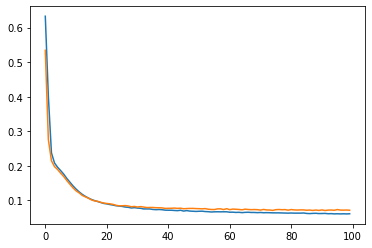

In [28]:
# Training done, let's look at the loss curves
all_train_running_losses = list(chain(train_state['train_loss']))
all_valid_running_losses = list(chain(train_state['val_loss']))

train_epoch_idx = range(len(train_state['train_loss']))
valid_epoch_idx = range(len(train_state['val_loss']))
# sns.lineplot(epoch_idx, all_losses)
sns.lineplot(train_epoch_idx, all_train_running_losses)
sns.lineplot(valid_epoch_idx, all_valid_running_losses)
plt.show()

In [29]:
classifier_state_dict = classifier.state_dict()
torch.save(classifier_state_dict, "/content/drive/MyDrive/NLP243/assignments/1/model/20221002/classifier_checkpoint_train_val_split_1.pt")

In [37]:
classifier.eval()

MLPMultiLabelClassifier(
  (fc1): Linear(in_features=101, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=19, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [43]:
def predict_labels(text, classifier, vectorizer, label_indexer,
                   decision_threshold=0.5):
    """Predict the rating of a review

    Args:
        text (str): the text of the movie
        classifier (ReviewClassifier): the trained model
        vectorizer (ReviewVectorizer): the corresponding vectorizer
        decision_threshold (float): The numerical boundary which
            separates the rating classes
    """

    processed_text = preprocess_text(text)
    vectorized_text = torch.tensor(vectorizer.vectorize(processed_text))
    y_pred = classifier(vectorized_text.squeeze())

    y_pred_normalized = F.sigmoid(y_pred)
    y_pred_labels = y_pred_normalized >= decision_threshold

    labels = [label_indexer.idx2label[_idx] for _idx, value in enumerate(y_pred_labels.tolist()) if value]
    return labels

test_movies_csv = '/content/drive/MyDrive/NLP243/assignments/1/hw1_test-2.csv'
test_movies_df = pd.read_csv(test_movies_csv)
test_movies_df.columns = ["id", "text"]
all_text_labels = []
all_text_ids = []
for _idx, _text in enumerate(test_movies_df.text, 0):
    labels = predict_labels(text=_text, classifier=classifier, vectorizer=vectorizer, label_indexer=label_indexer, decision_threshold=0.5)
    labels = ["" if _label == 'none' else _label for _label in labels]
    formatted_labels = " ".join(labels).strip()
    all_text_ids.append(_idx)
    all_text_labels.append(formatted_labels)
    print(_idx)
    print("text: {}".format(_text))
    print("labels: {}".format(formatted_labels))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0
text: star of thor
labels: 
1
text: who is in the movie the campaign
labels: movie.starring.actor
2
text: list the cast of the movie the campaign
labels: movie.starring.actor
3
text: who was in twilight
labels: movie.starring.actor
4
text: who is in vulguria
labels: movie.starring.actor
5
text: actor from lost
labels: movie.starring.actor
6
text: who played in the movie rocky
labels: movie.starring.actor
7
text: who played in the movie captain america
labels: movie.starring.actor
8
text: cast and crew for in july
labels: movie.starring.actor
9
text: who is in movie in july
labels: 
10
text: who's in star wars episode four
labels: movie.starring.actor
11
text: who was in apollo thirteen
labels: movie.starring.actor
12
text: who was apollo thirteen 's cast
labels: movie.starring.actor
13
text: search for information about the cast and crew of appolo thirteen
labels: movie.starring.actor
14
text: i would like to know more about the cast and crew of the movie apollo thirteen
labels: movi

In [54]:
submission_path = '/content/drive/MyDrive/NLP243/assignments/1/submission_1.csv'
submission_columns = ["ID", "CORE RELATIONS"]
submission_df = pd.DataFrame(columns=submission_columns, data={"ID": all_text_ids, "CORE RELATIONS": all_text_labels})
submission_df.set_index("ID")
print(submission_df)
submission_df.drop(submission_df.columns[[0]], axis=1, inplace=True)
print(submission_df)
submission_df.to_csv(submission_path)


      ID        CORE RELATIONS
0      0                      
1      1  movie.starring.actor
2      2  movie.starring.actor
3      3  movie.starring.actor
4      4  movie.starring.actor
..   ...                   ...
976  976                      
977  977  movie.starring.actor
978  978                      
979  979        movie.language
980  980                      

[981 rows x 2 columns]
           CORE RELATIONS
0                        
1    movie.starring.actor
2    movie.starring.actor
3    movie.starring.actor
4    movie.starring.actor
..                    ...
976                      
977  movie.starring.actor
978                      
979        movie.language
980                      

[981 rows x 1 columns]


In [ ]:
class MultiClassTrainer(object):
    
    def __init__(self, model, optimizer, loss_fn, device="cpu", log_every_n=None):
        self.model = model.to(device)
        self.optimizer = optimizer
        self.device = device
        self.loss_fn = loss_fn

        self.log_every_n = log_every_n if log_every_n else 0


    def _print_summary(self):
        print(self.model)
        print(self.optimizer)
        print(self.loss_fn)

    def evaluate(self, loader, labels):
        """
        Evaluate the model on a validation set
        """

        self.model.eval() # Run model in eval mode (disables dropout layer)

        batch_wise_true_labels = []
        batch_wise_predictions = []

        loss_history = []
        running_loss = 0.
        running_loss_history = []

        with torch.no_grad(): # Disable gradient computation - required only during training
            for i, batch_dict in tqdm(enumerate(loader)):
                # batch[0] shape: (batch_size, input_size)

                y_pred = self.model(batch_dict['x_data'].float().to(self.device))
                # logits shape: (batch_size, num_classes)
        
                # print("y_pred: {}".format(y_pred))

                # step 3. compute the loss
                loss = self.loss_func(y_pred, batch_dict['y_target'].squeeze().float().to(self.device))
                loss_batch = loss.item()
                running_loss += (loss_batch - running_loss) / (batch_index + 1)
                loss_history.append(loss_batch)
                running_loss += (loss_history[-1] - running_loss) / (i + 1) # Compute rolling average
                running_loss_history.append(running_loss)

                # logits : [batch_size, num_classes] and each of the values in logits can be anything (-infinity, +infity)
                # Converts the raw outputs into probabilities for each class using softmax
                y_pred_normalized = F.sigmoid(logits)
                y_pred_labels = y_pred_normalized >= 0.5
                # probs shape: (batch_size, num_classes)

                batch_wise_true_labels.append(batch_dict['y_target'].tolist())
                batch_wise_predictions.append(y_pred_labels.tolist())
        
        # flatten the list of predictions using itertools
        all_true_labels = list(chain.from_iterable(batch_wise_true_labels))
        all_predictions = list(chain.from_iterable(batch_wise_predictions))

        # Now we can generate a classification report
        print("Classification report after epoch:")
        print(classification_report(all_true_labels, all_predictions, target_names=labels))

        return loss_history, running_loss_history

    def get_model_dict(self):
        return self.model.state_dict()

In [93]:
for _x in train_state['train_loss']:
  print(_x)

0.19637909792444277
0.10271475106846645


In [94]:
for _x in train_state['train_p']:
  print(_x)

0.03517316017316016
0.39475108225108274


In [95]:
for _x in train_state['train_r']:
  print(_x)

0.03490259740259739
0.3870400432900438


In [96]:
for _x in train_state['train_f1']:
  print(_x)

0.034992784992784985
0.38928571428571446


In [97]:
for _x in train_state['val_loss']:
  print(_x)

0.12506512976634554
0.09035531236302279


In [98]:
for _x in train_state['val_p']:
  print(_x)

0.1861471861471862
0.5064935064935064


In [99]:
for _x in train_state['val_r']:
  print(_x)

0.185064935064935
0.48917748917748927


In [100]:
for _x in train_state['val_f1']:
  print(_x)

0.1854256854256854
0.494949494949495


In [92]:
def compute_metrics(y_pred, y_target):

  # print("batch size: {}".format(args.batch_size))

  p = 0
  r = 0
  f1 = 0
  print("y_target")
  print(y_target)
  print()
  print("y_target_refined")
  print(y_target >= 0.5)
  print()
  print("y_pred")
  print(y_pred)
  print()
  print("y_pred_refined")
  print(y_pred >= 0.5)
  print()

  p = precision_score(y_target.to('cpu') >= 0.5, y_pred.to('cpu') >=0.5, average="samples")
  r = recall_score(y_target.to('cpu') >= 0.5, y_pred.to('cpu') >=0.5, average="samples")
  f1 = f1_score(y_target.to('cpu') >= 0.5, y_pred.to('cpu') >=0.5, average="samples")

  print("precision: {}".format(p))
  print("recall: {}".format(r))
  print("f1: {}".format(f1))

  # if args.batch_size <= 1:
  #   f1_idx = f1_score(y_target, y_pred >=0.5, average="samples")
  #   p_idx = precision_score(y_target, y_pred >=0.5, average="samples")
  #   r_idx = recall_score(y_target, y_pred >=0.5, average="samples")
  #   # acc = sklearn.accuracy(y_target, y_pred >=0.5, average="samples")

  #   p += p_idx
  #   r += r_idx
  #   f1 += f1_idx
  
  # else:
  #   for _idx in range(args.batch_size):
  #     f1_idx = f1_score(y_target[_idx], y_pred[_idx] >=0.5, average="samples")
  #     p_idx = precision_score(y_target[_idx], y_pred[_idx] >=0.5, average="samples")
  #     r_idx = recall_score(y_target[_idx], y_pred[_idx] >=0.5, average="samples")
  #     # acc = sklearn.accuracy(y_target, y_pred >=0.5, average="samples")

  #     p += p_idx
  #     r += r_idx
  #     f1 += f1_idx

  # p = p/args.batch_size
  # r = r/args.batch_size
  # f1 = f1/args.batch_size
  
  return p, r, f1